Nettoyage de données

In [55]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, upper, when

In [2]:
# Créer une session Spark
spark = SparkSession.builder.appName("NettoyageDonnees").getOrCreate()

In [3]:
# Charger les données
file_path = r"/content/maladie_observations.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [4]:
# Afficher les colonnes pour vérifier la structure
print("Colonnes initiales :", df.columns)

Colonnes initiales : ['temperature', 'pouls', 'oxygene', 'glycemie', 'tension', 'label']


In [10]:
# Afficher un aperçu du dataset
print("Aperçu des données :")
print(df.head())

Aperçu des données :
Row(temperature=39.087105722227975, pouls=97.0, oxygene=93.37415234554878, glycemie=98.37566366966453, tension=95, label=1)


In [11]:
# Vérification des colonnes initiales
print("\nColonnes présentes :")
print(df.columns)


Colonnes présentes :
['temperature', 'pouls', 'oxygene', 'glycemie', 'tension', 'label']


In [5]:
# Étape 1 : Supprimer les lignes avec des valeurs nulles
df_clean = df.dropna(how="any")  # Supprime les lignes contenant des valeurs nulles

In [14]:
# 2. Suppression des doublons
df = df.distinct()  # Use distinct() to remove duplicates in PySpark
print("\nAprès suppression des doublons :", df.count(), "rows and", len(df.columns), "columns") # Use count() and len(df.columns) for dimensions


Après suppression des doublons : 5725 rows and 6 columns


In [15]:
# Supprimer les lignes avec un label manquant
df = df.filter(col('label').isNotNull())

In [18]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col

# 3. Vérification et conversion des types
# Get numerical columns dynamically
numerical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, DoubleType)]

# Convertir les colonnes en DoubleType si nécessaire
for col_name in numerical_cols:
    df = df.withColumn(col_name, col(col_name).cast(DoubleType()))

In [19]:
# 4. Gestion des valeurs aberrantes
# Définir les plages valides et filtrer les valeurs aberrantes
df = df.filter(
    (col('temperature') >= 35) & (col('temperature') <= 42) &
    (col('pouls') >= 40) & (col('pouls') <= 180) &
    (col('oxygene') >= 70) & (col('oxygene') <= 100) &
    (col('glycemie') >= 60) & (col('glycemie') <= 200) &
    (col('tension') >= 80) & (col('tension') <= 200)
)

print("Après suppression des valeurs aberrantes :")
df.show()

Après suppression des valeurs aberrantes :
+------------------+-----+-----------------+------------------+-------+-----+
|       temperature|pouls|          oxygene|          glycemie|tension|label|
+------------------+-----+-----------------+------------------+-------+-----+
| 38.57950290582754|111.0|97.28280703409155|110.17791220521056|     90|    1|
| 37.14867643907358| 60.0|99.06023113007063|107.24962379903829|    123|    0|
| 38.10902385487565|102.0|93.54237615313525|111.65321108918855|    138|    1|
| 38.72596568080775|106.0|93.82545118296318|109.59027577067576|    113|    1|
| 36.76888638790094| 54.0|99.17826680631208|107.18522014693751|     98|    0|
| 38.53117519661472| 98.0|92.05867628183456|119.67514565012567|    115|    1|
| 38.58726478351975|112.0|94.05160696144836| 74.18119839156644|     98|    1|
| 37.36389756518301| 78.0| 99.6706129217169|116.29913948721533|    126|    0|
|38.658642554965006|106.0|92.08110363019831|  96.4475038079227|    133|    1|
| 39.35168249017475| 

In [20]:
# 5. Standardisation
# Standardiser les colonnes numériques
from pyspark.ml.feature import StandardScaler, VectorAssembler

# VectorAssembler pour combiner les colonnes
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
df = assembler.transform(df)

# Appliquer le StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)
# Afficher les données standardisées
print("Données après standardisation :")
df.select("scaled_features").show()

Données après standardisation :
+--------------------+
|     scaled_features|
+--------------------+
|[0.47552899318749...|
|[-0.6892399095880...|
|[0.09253400344613...|
|[0.59475748781981...|
|[-0.9984092263906...|
|[0.43618766554126...|
|[0.48184757477170...|
|[-0.5140384573243...|
|[0.53995287996463...|
|[1.10412427577700...|
|[1.08978979490959...|
|[-1.3210005948893...|
|[0.17167941899400...|
|[0.01369591285462...|
|[0.88270429521144...|
|[0.08759566971759...|
|[-0.6926160670122...|
|[0.93468903932494...|
|[1.48401689807109...|
|[1.34976225627102...|
+--------------------+
only showing top 20 rows



In [22]:
# 6. Sauvegarder le dataset nettoyé
# Select only the relevant columns, excluding the 'features' and 'scaled_features' columns
df_to_save = df.select([col for col in df.columns if col not in ['features', 'scaled_features']])

df_to_save.write.csv('dataset_nettoye.csv', header=True, mode='overwrite')
print("Le dataset nettoyé a été sauvegardé dans 'dataset_nettoye.csv'.")

Le dataset nettoyé a été sauvegardé dans 'dataset_nettoye.csv'.


Statistiques Descriptives

In [23]:
from pyspark.sql.functions import col, mean, stddev, min, max, count

# Colonnes numériques sur lesquelles calculer les statistiques descriptives
numerical_cols = ['temperature', 'pouls', 'oxygene', 'glycemie', 'tension']

# Calculer les statistiques descriptives pour chaque colonne numérique
for col_name in numerical_cols:
    print(f"\nStatistiques pour la colonne {col_name}:")
    df.select(
        count(col(col_name)).alias("Nombre de valeurs"),
        mean(col(col_name)).alias("Moyenne"),
        stddev(col(col_name)).alias("Écart-type"),
        min(col(col_name)).alias("Minimum"),
        max(col(col_name)).alias("Maximum")
    ).show()

# Statistiques globales avec summary() (plus rapide pour un aperçu)
print("\nStatistiques globales pour les colonnes numériques:")
df.select(numerical_cols).summary().show()


Statistiques pour la colonne temperature:
+-----------------+----------------+------------------+-----------------+----------------+
|Nombre de valeurs|         Moyenne|        Écart-type|          Minimum|         Maximum|
+-----------------+----------------+------------------+-----------------+----------------+
|             5625|37.9953531508501|1.2284209025021737|36.00061543415876|39.9996984889728|
+-----------------+----------------+------------------+-----------------+----------------+


Statistiques pour la colonne pouls:
+-----------------+-----------------+------------------+-------+-------+
|Nombre de valeurs|          Moyenne|        Écart-type|Minimum|Maximum|
+-----------------+-----------------+------------------+-------+-------+
|             5625|86.77955555555556|21.644460955599698|   50.0|  119.0|
+-----------------+-----------------+------------------+-------+-------+


Statistiques pour la colonne oxygene:
+-----------------+-----------------+------------------+---

Visualisation

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
from pyspark.sql import functions as F
# Calculer les statistiques descriptives pour une colonne (par exemple, "temperature")
stats = df.select(
    F.mean("temperature").alias("mean"),
    F.stddev("temperature").alias("stddev"),
    F.min("temperature").alias("min"),
    F.max("temperature").alias("max")
).toPandas()
# Conversion en pandas pour faciliter la visualisation
data = df.select("temperature").toPandas()

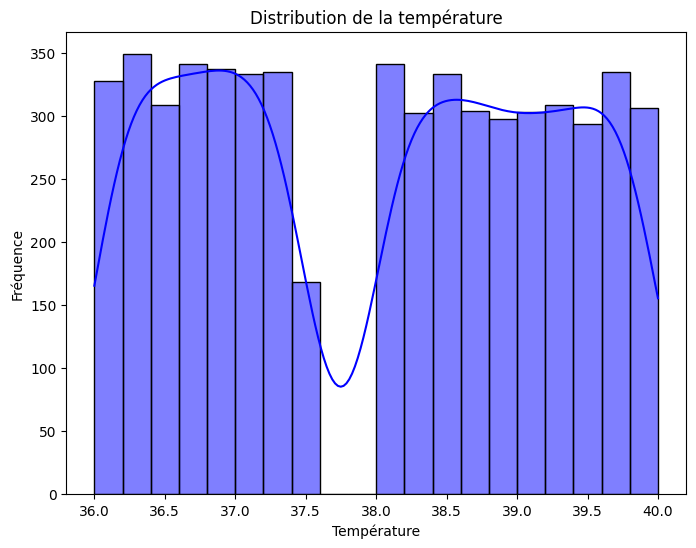

In [28]:
# Histogramme de la colonne "temperature"
plt.figure(figsize=(8, 6))
sns.histplot(data['temperature'], bins=20, kde=True, color='blue')
plt.title("Distribution de la température")
plt.xlabel("Température")
plt.ylabel("Fréquence")
plt.show()

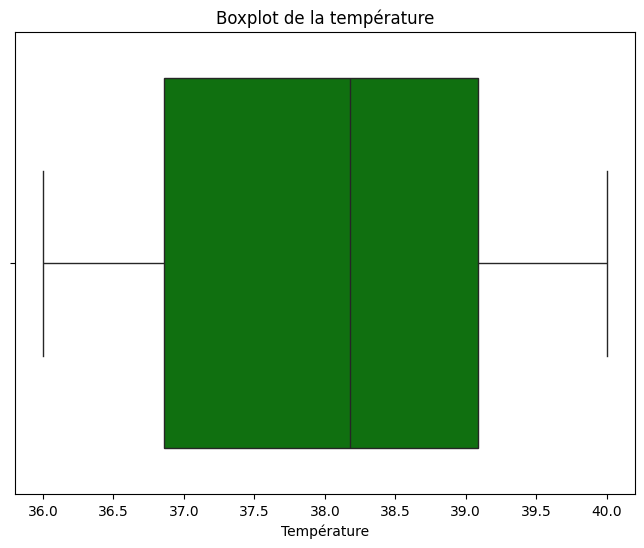

In [29]:
# Boxplot de la colonne "temperature"
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['temperature'], color='green')
plt.title("Boxplot de la température")
plt.xlabel("Température")
plt.show()

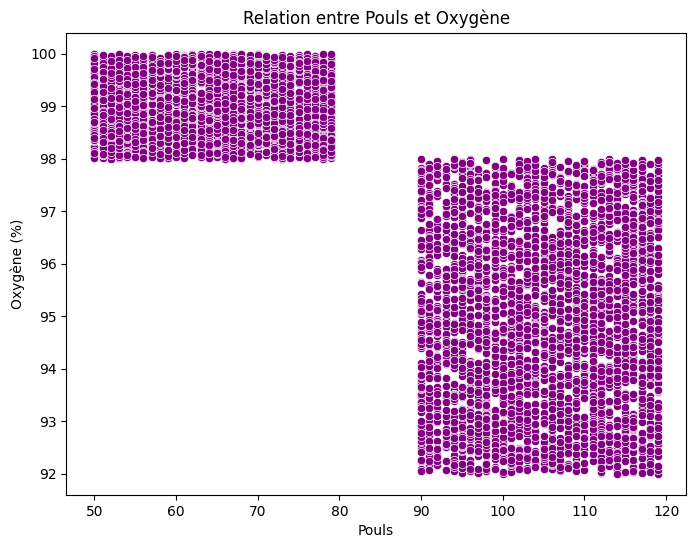

In [30]:
# Scatter plot entre "pouls" et "oxygene"
scatter_data = df.select("pouls", "oxygene").toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=scatter_data['pouls'], y=scatter_data['oxygene'], color='purple')
plt.title("Relation entre Pouls et Oxygène")
plt.xlabel("Pouls")
plt.ylabel("Oxygène (%)")
plt.show()

<ipython-input-31-ddec9ff11375>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=label_data, palette='viridis')


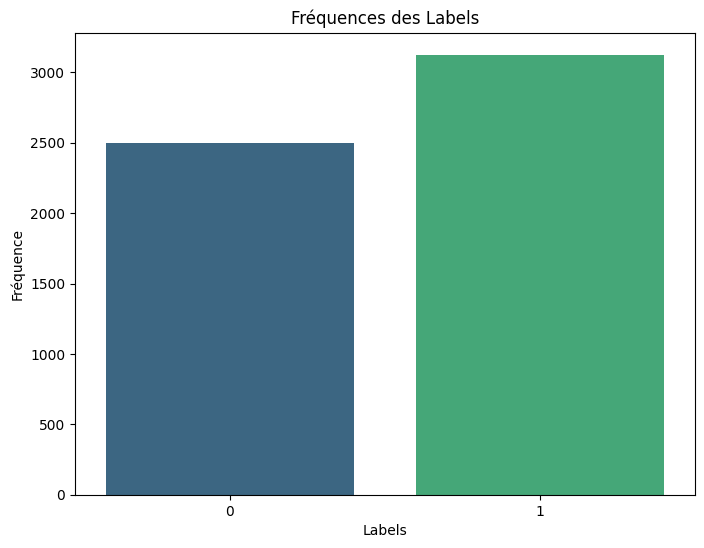

In [31]:
# Exemple pour la colonne "label"
label_data = df.groupBy("label").count().toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x='label', y='count', data=label_data, palette='viridis')
plt.title("Fréquences des Labels")
plt.xlabel("Labels")
plt.ylabel("Fréquence")
plt.show()

Modélisation et Apprentissage Automatique

In [46]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F

# Supposez que df_clean est votre DataFrame avec les colonnes :
# ['temperature', 'pouls', 'oxygene', 'glycemie', 'tension', 'label']

# Assemblez les caractéristiques en un vecteur unique
assembler = VectorAssembler(
    inputCols=["temperature", "pouls", "oxygene", "glycemie", "tension"],
    outputCol="features"
)

# Définir le modèle de régression logistique
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Créer un pipeline pour la transformation et l'entraînement
pipeline = Pipeline(stages=[assembler, lr])

# Divisez les données en ensemble d'entraînement et de test (80% train, 20% test)
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=1234)


In [48]:
# Entraînez le modèle
# Check if 'features' column already exists
if 'features' not in train_data.columns:
    model = pipeline.fit(train_data)
else:
    # If it exists, drop it and then fit the model
    train_data = train_data.drop('features')
    model = pipeline.fit(train_data)


# Faites des prédictions sur l'ensemble de test
# Check if 'features' column already exists
if 'features' not in test_data.columns:
    predictions = model.transform(test_data)
else:
    # If it exists, drop it and then transform
    test_data = test_data.drop('features')
    predictions = model.transform(test_data)

# Affichez quelques prédictions
predictions.select("label", "prediction", "probability").show(5)

+-----+----------+-----------+
|label|prediction|probability|
+-----+----------+-----------+
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
+-----+----------+-----------+
only showing top 5 rows



In [49]:
# Initialiser l'évaluateur pour évaluer la performance du modèle
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")

# Calculer l'AUC (aire sous la courbe ROC)
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")


AUC: 1.0


In [51]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Créer un évaluateur pour la précision, le rappel et le F1-score
# Use 'weightedPrecision', 'weightedRecall', and 'f1' for binary classification
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Calcul des différentes métriques
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")

Precision: 1.0
Recall: 1.0
F1-Score: 1.0


In [54]:
# Exemple de prédiction sur une nouvelle observation
new_data = spark.createDataFrame([(37.5, 80, 98, 90, 120)], ["temperature", "pouls", "oxygene", "glycemie", "tension"])

# Prédiction avec le modèle (directly, without using assembler again)
new_prediction = model.transform(new_data)

# Affichage de la prédiction
new_prediction.select("prediction", "probability").show()

# Access the prediction correctly (using first row)
if new_prediction.first().prediction == 0:
    print('Cette personne ne est pas malade')
else:
    print('Cette personne est malade')

+----------+--------------------+
|prediction|         probability|
+----------+--------------------+
|       0.0|[0.99975929505817...|
+----------+--------------------+

Cette personne ne est pas malade
